# Лабораторная работа №4. Сверточные нейронные сети

In [48]:
from tensorflow.keras.datasets import mnist

Функция load_data загружает обучающие и тестовые наборы MNIST

In [49]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [50]:
print("Размер изображений обучающего набора:", X_train.shape)
print("Размер меток обучающего набора:", y_train.shape)
print("Размер изображений тестового набора:", X_test.shape)
print("Размер меток тестового набора:", y_test.shape)

Размер изображений обучающего набора: (60000, 28, 28)
Размер меток обучающего набора: (60000,)
Размер изображений тестового набора: (10000, 28, 28)
Размер меток тестового набора: (10000,)


## Визуализация цифр

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2)

Выводим случайно выбранный набор из 24 изображений обучающего набора MNIST.
Функция choice библиотеки NumPy случайным образом выбирает количество элементов, заданное вторым аргументом.

In [52]:
import numpy as np
index = np.random.choice(np.arange(len(X_train)), 24, replace=False)

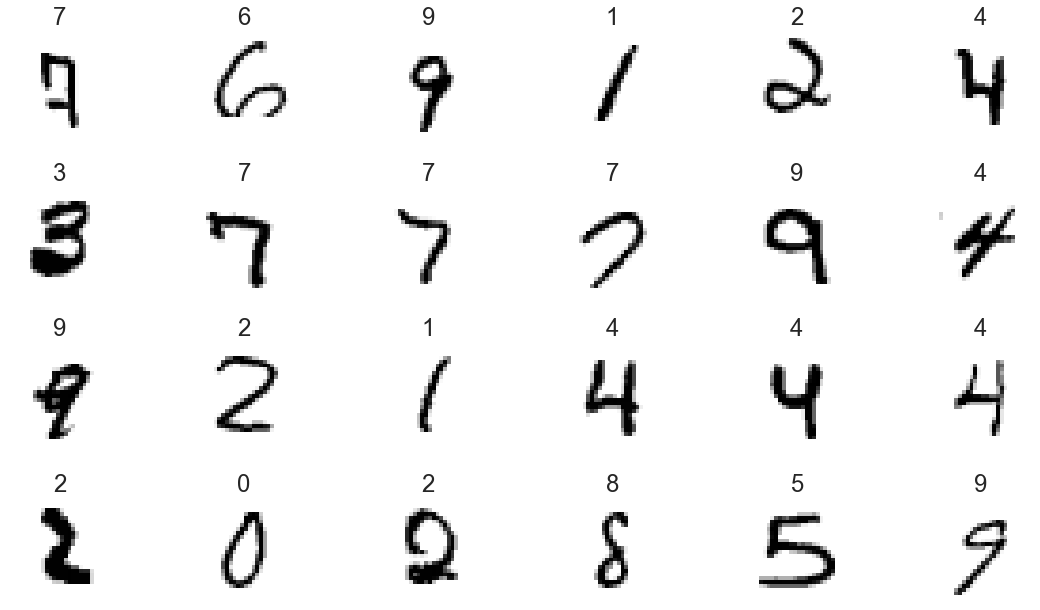

In [53]:
figure, axes = plt.subplots(nrows=4, ncols=6, figsize=(16, 9))

for item in zip(axes.ravel(), X_train[index], y_train[index]):
    axes, image, target = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_xticks([])  # remove x-axis tick marks
    axes.set_yticks([])  # remove y-axis tick marks
    axes.set_title(target)
plt.tight_layout()

## Подготовка данных

#### Переформатирование изображений

В наборе MNIST ширина и высота каждого изображения равны 28 пикселам, при этом каждый пиксел имеет один канал (оттенок серого от 0 до 255).

Преобразуем обучающие и тестовые изображения к правильным размерам для использования в сверточной нейронной сети.

In [54]:
X_train = X_train.reshape((60000, 28, 28, 1)) 
print("Размер изображений обучающего набора:", X_train.shape)

X_test = X_test.reshape((10000, 28, 28, 1))
print("Размер изображений тестового набора:", X_test.shape)

Размер изображений обучающего набора: (60000, 28, 28, 1)
Размер изображений тестового набора: (10000, 28, 28, 1)


#### Нормализация данных изображений

В MNIST каждый пиксел представлен целым числом в диапазоне 0–255. При помощи метода astype преобразуем значения в 32-разрядные (4-байтовые) числа с плавающей точкой.

In [55]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

####  Преобразование меток из целых чисел в категорийные данные

Метки необходимо преобразовать в категорийные данные, то есть массивы категорий, соответствующие формату прогнозов. Данные преобразуются в массивы значений 1.0 и 0.0, в котором только один элемент равен 1.0, а остальные равны 0.0.

Модуль tensorflow.keras.utils предоставляет функцию to_categorical для выполнения прямого унитарного кодирования. Функция подсчитывает уникальные категории, а затем для каждого закодированного элемента создает массив соответствующей длины со значением 1.0 в нужной позиции. 

In [56]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)

In [57]:
print(y_train.shape)
print(y_train[0])
y_test = to_categorical(y_test)
print(y_test.shape)

(60000, 10)
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
(10000, 10)


## Создание нейронной сети

In [58]:
from tensorflow.keras.models import Sequential 
cnn = Sequential()

#### Добавление уровней в сеть

In [59]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D

#### Добавление сверточного уровня

In [60]:
cnn.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))

filters=64 — количество фильтров в итоговой карте признаков;

kernel_size=(3, 3) — размер ядра, используемого в каждом фильтре;

activation='relu' — для получения вывода уровня используется функция  активации  'relu'  (Rectified  Linear  Unit).  'relu'  —  наиболее  часто используемая  функция  активации  в  современных  сетях  глубокого  обучения

In [61]:
cnn.add(MaxPooling2D(pool_size=(2, 2)))

Добавим второй сверточный уровень со 128 фильтрами, за которым следует второй объединяющий уровень для сокращения степени размерности на 75%.

In [62]:
cnn.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))

#### Одномерное преобразование результатов

Для подготовки одномерных прогнозов сначала необходимо преобразовать трехмерный выход предыдущего уровня к одному измерению. Уровень Keras Flatten преобразует свой вход к одному измерению. В данном случае выход уровня Flatten будет иметь размеры 1 × 3200 (то есть 5*5*128):

In [63]:
cnn.add(Flatten())

#### Добавление уровня Dense для сокращения количества признаков

In [64]:
cnn.add(Dense(units=128, activation='relu'))

#### Добавление еще одного уровня Dense для получения итогового результата

In [65]:
 cnn.add(Dense(units=10, activation='softmax'))

#### Вывод сводной информации модели

In [70]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 128)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3200)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

#### Компиляция модели

In [74]:
cnn.compile(optimizer='adam', 
            loss='categorical_crossentropy',
            metrics=['accuracy'])

optimizer='adam'  —  оптимизатор,  используемый  моделью  для  регули-
ровки весов в нейронной сети в процессе обучения;

loss='categorical_crossentropy'  —  функция  потерь,  используемая  оп-
тимизатором  в  сетях  множественной  классификации, которая будет прогнозировать 10 классов.

metrics=['accuracy']  —  список  метрик,  которые  будут  производиться 
сетью, для того чтобы упростить вам оценку модели.

## Обучение и оценка модели

Как  и  в  Scikit-learn,  в  первых  двух  аргументах  передаются  обучающие данные и категорийные метки целей.

Аргумент epochs сообщает, сколько раз модель должна обработать весь набор обучающих данных.

Аргумент  batch_size  задает  количество  образцов,  обрабатываемых  за один  раз  в  каждой  эпохе.  Для  большинства  моделей  выбирается  степень 2 от 32 до 512.

Если вы укажете проверочные данные, то после каждой эпохи модель использует их для построения прогнозов и вывода проверочных значений потерь и точности. В данном случае мы использовали аргумент validation_split для обозначения того, что модель должна зарезервировать последние 10% (0.1) обучающих образцов для проверки.

In [75]:
cnn.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1)

Epoch 1/5
844/844 [==============================] - 63s 74ms/step - loss: 0.1439 - accuracy: 0.9561 - val_loss: 0.0483 - val_accuracy: 0.9863
Epoch 2/5
844/844 [==============================] - 67s 79ms/step - loss: 0.0448 - accuracy: 0.9859 - val_loss: 0.0371 - val_accuracy: 0.9900
Epoch 3/5
844/844 [==============================] - 67s 79ms/step - loss: 0.0290 - accuracy: 0.9907 - val_loss: 0.0384 - val_accuracy: 0.9885
Epoch 4/5
844/844 [==============================] - 71s 84ms/step - loss: 0.0214 - accuracy: 0.9931 - val_loss: 0.0327 - val_accuracy: 0.9913
Epoch 5/5
844/844 [==============================] - 72s 86ms/step - loss: 0.0141 - accuracy: 0.9954 - val_loss: 0.0421 - val_accuracy: 0.9887


В процессе обучения метод fit выводит различную информацию: прогресс каждой эпохи, длительность выполнения эпохи (в нашем случае каждая занимала 67-72 секунд) и оценочные метрики для текущего прохода. В последней эпохе этой модели точность достигла 99,54% для обучающих образцов (acc) и 98,87% для проверочных образцов (val_acc).

Теперь точность модели можно проверить на данных, неизвестных модели.  Метод evaluate модели выводит продолжительность обработки тестовых образцов.

In [76]:
loss, accuracy = cnn.evaluate(X_test, y_test)

313/313 [==============================] - 4s 11ms/step - loss: 0.0327 - accuracy: 0.9899


In [77]:
print(loss)
print(accuracy)

0.03268462046980858
0.9898999929428101


Из этого вывода следует, что наша модель сверточных нейронных сетей обеспечивает точность 98,98% при прогнозировании меток для незнакомых данных.

#### Построение прогнозов

Метод predict модели прогнозирует классы изображений цифр из своего аргумента-массива (X_test)

In [78]:
predictions = cnn.predict(X_test)
y_test[0]

313/313 [==============================] - 4s 11ms/step


array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [79]:
for index, probability in enumerate(predictions[0]):
    print(f'{index}: {probability:.10%}') 

0: 0.0000000254%
1: 0.0000002968%
2: 0.0000115779%
3: 0.0000028814%
4: 0.0000000000%
5: 0.0000000062%
6: 0.0000000000%
7: 99.9999880791%
8: 0.0000000268%
9: 0.0000048971%


#### Поиск неправильных прогнозов

In [80]:
images = X_test.reshape((10000, 28, 28))
incorrect_predictions = []
for i, (p, e) in enumerate(zip(predictions, y_test)):
    predicted, expected = np.argmax(p), np.argmax(e)
    if predicted != expected:
        incorrect_predictions.append((i, images[i], predicted, expected))

Проверяем общее количество ошибочных прогнозов 

In [81]:
len(incorrect_predictions)

101

#### Визуализация ошибочных предсказаний

Выводит 24 неправильных изображения с указанием индекса каждого изображения (index), прогнозируемого значения (p) и ожидаемого значения (e):

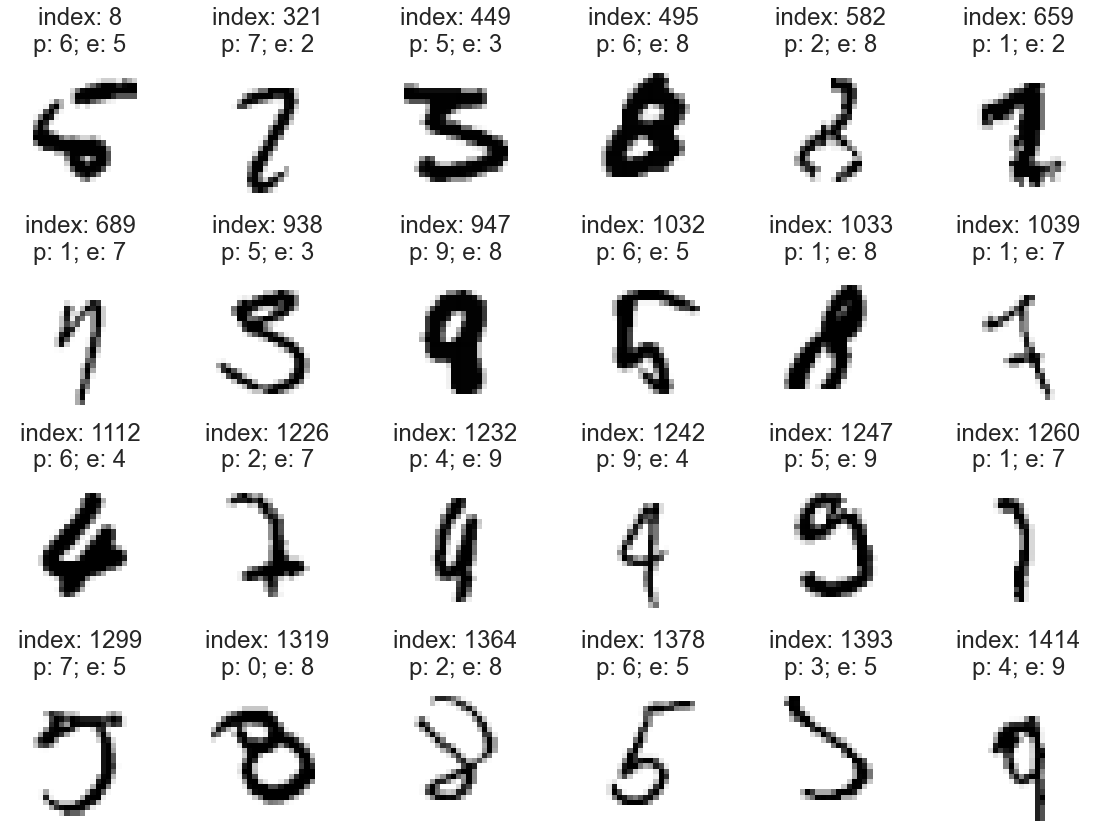

In [82]:
figure, axes = plt.subplots(nrows=4, ncols=6, figsize=(16, 12))
for axes, item in zip(axes.ravel(), incorrect_predictions):
    index, image, predicted, expected = item
    axes.imshow(image, cmap=plt.cm.gray_r)
    axes.set_xticks([])  # remove x-axis tick marks
    axes.set_yticks([])  # remove y-axis tick marks
    axes.set_title(f'index: {index}\np: {predicted}; e: {expected}')
plt.tight_layout()

#### Вывод вероятностей для нескольких ошибочных прогнозов

In [83]:
def display_probabilities(prediction):
    for index, probability in enumerate(prediction):
        print(f'{index}: {probability:.10%}')

In [84]:
display_probabilities(predictions[495])

0: 8.0941952765%
1: 0.0000309694%
2: 6.8365544081%
3: 0.0024410716%
4: 0.0013618028%
5: 0.0004199417%
6: 64.2143905163%
7: 0.0000015116%
8: 20.8482846618%
9: 0.0023292978%


In [86]:
display_probabilities(predictions[582])

0: 0.0000014415%
1: 0.0002219178%
2: 99.9540925026%
3: 0.0318473001%
4: 0.0000000020%
5: 0.0000000040%
6: 0.0000216285%
7: 0.0000000911%
8: 0.0138165313%
9: 0.0000000006%


In [87]:
display_probabilities(predictions[659])

0: 0.0001646768%
1: 70.3166782856%
2: 0.3711419413%
3: 0.0053441679%
4: 0.0000373778%
5: 0.0000010204%
6: 0.0000001214%
7: 29.3062299490%
8: 0.0000017328%
9: 0.0004123268%


## Сохранение и загрузка модели

In [88]:
cnn.save('mnist_cnn.h5')